# Importing the dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%time
!unzip -q drive/MyDrive/dataset/dataset_zip.zip -d ./extracted_audios

CPU times: user 471 ms, sys: 73.9 ms, total: 544 ms
Wall time: 1min 24s


In [3]:
# Importing the dependencies
import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm

In [4]:
# Importing the mappings csv file
mappings = 'drive/MyDrive/dataset/filename_to_classid_mapping.csv'
dataset = 'extracted_audios'

In [5]:
labels = pd.read_csv(mappings, names = ['filenames', 'class_id'])

In [6]:
labels

,filenames,class_id
0,0001.wav,1
1,0002.wav,1
2,0003.wav,1
3,0004.wav,1
4,0005.wav,1
...,...,...
1607,1608.wav,5
1608,1609.wav,5
1609,1610.wav,5
1610,1611.wav,5


# Feature Extraction

**Extracting MFCC features**

In [7]:
def MFCC_features(file_name):
  audio, sample_rate = librosa.load(dataset + '/' + file_name)

  desired_length = 661500

  if len(audio) < desired_length:
    audio = np.pad(audio, (0, desired_length - len(audio)), mode = 'constant')

  MFCC = librosa.feature.mfcc(y = audio, sr = sample_rate, n_mfcc = 13)
  MFCC_scaled = np.mean(MFCC.T, axis = 0)

  return MFCC_scaled

In [8]:
# Create a numpy matrix to store the mfcc vectors
X = np.zeros([1612, 13])
# A vector to store the output labels
Y = np.zeros(len(labels))

In [9]:
# Extract the features
for index, rows in tqdm(labels.iterrows()):
  file_name = rows['filenames']
  class_id = rows['class_id']

  MFCC = MFCC_features(file_name)
  X[index] = MFCC
  Y[index] = class_id

1612it [02:53,  9.31it/s]


In [10]:
X.shape

(1612, 13)

In [11]:
# Transform the output labels from range (1 - 6) to (0 - 5)
y_transform = Y - 1

# CLASSIFICATION

In [12]:
# Import the depencies
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [13]:
# Perform the train test split
x_train, x_test, y_train, y_test = train_test_split(X, y_transform, test_size = 0.20)

In [14]:
x_train.shape

(1289, 13)

In [15]:
y_train.shape

(1289,)

In [16]:
x_train[0]

array([-3.91552094e+02, -1.00959015e+01, -1.29657087e+01, -5.39978838e+00,
       -5.31013489e+00, -3.36175948e-01, -3.53993249e+00, -9.33654010e-02,
       -2.48959374e+00,  2.52053761e+00, -7.62706161e-01,  2.23532724e+00,
       -1.85328627e+00])

# Building Model


**Build model**


In [17]:

#   create model
model = keras.Sequential()

#   2 LSTM layers
model.add(keras.layers.LSTM(128, input_shape = (13, 1), return_sequences = "True"))
model.add(keras.layers.LSTM(64))

#   Dense layer
model.add(keras.layers.Dense(64, activation = "tanh"))
model.add(keras.layers.Dropout(0.3))

#   output layer
model.add(keras.layers.Dense(6, activation = "softmax"))



In [18]:
model.compile(
    optimizer = 'Adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 13, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 120518 (470.77 KB)
Trainable params: 120518 (470.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100)

Epoch 1/100
41/41 [==============================] - 7s 36ms/step - loss: 1.5453 - accuracy: 0.4011 - val_loss: 1.3539 - val_accuracy: 0.4737
Epoch 2/100
41/41 [==============================] - 0s 11ms/step - loss: 1.3149 - accuracy: 0.5221 - val_loss: 1.2265 - val_accuracy: 0.5356
Epoch 3/100
41/41 [==============================] - 0s 10ms/step - loss: 1.2317 - accuracy: 0.5283 - val_loss: 1.1467 - val_accuracy: 0.6099
Epoch 4/100
41/41 [==============================] - 1s 13ms/step - loss: 1.1047 - accuracy: 0.6090 - val_loss: 1.0682 - val_accuracy: 0.6285
Epoch 5/100
41/41 [==============================] - 0s 11ms/step - loss: 1.0514 - accuracy: 0.6292 - val_loss: 0.9654 - val_accuracy: 0.6409
Epoch 6/100
41/41 [==============================] - 0s 11ms/step - loss: 0.9166 - accuracy: 0.6850 - val_loss: 0.8545 - val_accuracy: 0.7028
Epoch 7/100
41/41 [==============================] - 0s 11ms/step - loss: 0.8229 - accuracy: 0.7153 - val_loss: 0.7604 - val_accuracy: 0.7399
Epoch 

**Saved Models**

In [21]:
estimator = model.evaluate(x_test, y_test)

11/11 [==============================] - 0s 4ms/step - loss: 0.2578 - accuracy: 0.9536


In [40]:
predicted = model.predict(x_test)
predicted

11/11 [==============================] - 0s 3ms/step


array([[9.6045011e-01, 6.6016932e-05, 1.1858272e-05, 2.7246220e-05,
        6.6176947e-04, 3.8782865e-02],
       [7.6139381e-04, 3.0064524e-05, 1.6055068e-05, 4.6041492e-05,
        6.2672725e-06, 9.9914014e-01],
       [4.5380684e-06, 9.4115021e-06, 8.2796701e-05, 7.1952832e-06,
        9.0488868e-07, 9.9989510e-01],
       ...,
       [9.5764954e-06, 4.6981296e-07, 9.9994111e-01, 4.5749428e-05,
        3.8614758e-08, 3.0180429e-06],
       [1.3703313e-04, 9.9790949e-01, 1.5950600e-03, 1.3421514e-04,
        7.9180636e-06, 2.1616249e-04],
       [4.9756291e-06, 2.7613005e-06, 6.2451926e-07, 4.3545674e-06,
        8.9249812e-07, 9.9998641e-01]], dtype=float32)

In [41]:
predicted[0]

array([9.6045011e-01, 6.6016932e-05, 1.1858272e-05, 2.7246220e-05,
       6.6176947e-04, 3.8782865e-02], dtype=float32)

In [42]:
label = np.argmax(predicted[0])

In [43]:
label

0

In [44]:
y_test[0]

0.0

In [45]:
y_predicted = [np.argmax(i) for i in predicted]

In [46]:
y_test[:5]

array([0., 5., 5., 2., 5.])

In [47]:
y_predicted[:5]

[0, 5, 5, 2, 5]

In [48]:
cm = tf.math.confusion_matrix(labels = y_test, predictions = y_predicted)

In [49]:
import matplotlib.pyplot as plt

Text(95.72222222222221, 0.5, 'Truth')

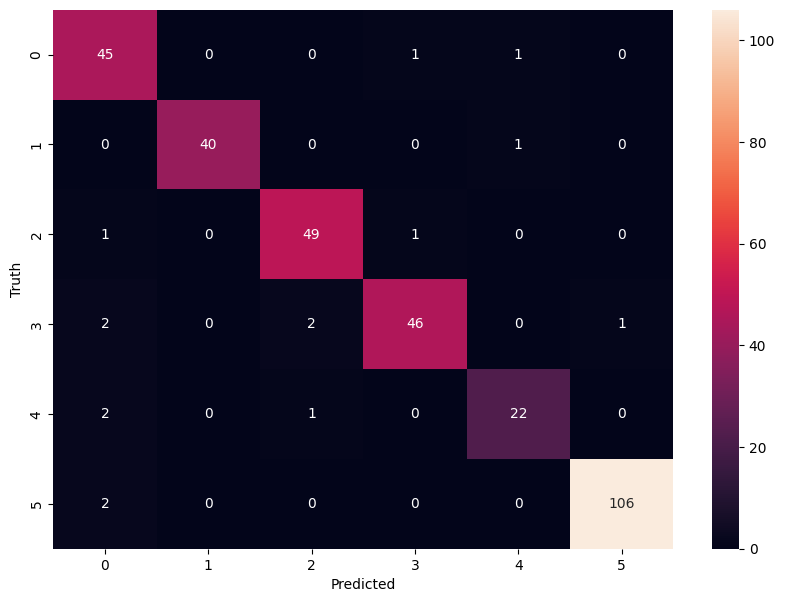

In [50]:
import seaborn as sn
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [51]:
from sklearn.metrics import classification_report

In [52]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91        47
         1.0       1.00      0.98      0.99        41
         2.0       0.94      0.96      0.95        51
         3.0       0.96      0.90      0.93        51
         4.0       0.92      0.88      0.90        25
         5.0       0.99      0.98      0.99       108

    accuracy                           0.95       323
   macro avg       0.95      0.94      0.94       323
weighted avg       0.96      0.95      0.95       323



In [57]:
def plot_history(history):

    fig, axis = plt.subplots(2)

    #create accuracy subplot
    axis[0].plot(history.history["accuracy"], label = "train_accuracy")
    axis[0].plot(history.history["val_accuracy"], label = "test_accuracy")
    axis[0].set_ylabel("Accuracy")
    axis[0].legend(loc = "lower right")
    axis[0].set_title("accuracy eval")

    #create error subplot
    axis[1].plot(history.history["loss"], label = "train_error")
    axis[1].plot(history.history["val_loss"], label = "test_error")
    axis[1].set_xlabel("Epoch")
    axis[1].set_ylabel("Loss")
    axis[1].legend(loc = "upper right")
    axis[1].set_title("Error eval")


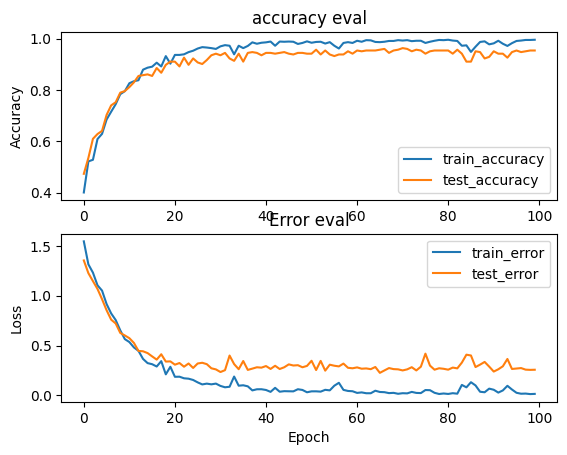

In [58]:
plot_history(history)

In [59]:
import numpy as np

# Assuming you have a confusion matrix in the form of a NumPy array
confusion_matrix = cm

# Calculate precision, recall, F1 score, and accuracy for each class
precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)
accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)

# Calculate overall precision, recall, F1 score, and accuracy
overall_precision = np.mean(precision)
overall_recall = np.mean(recall)
overall_f1_score = np.mean(f1_score)
overall_accuracy = accuracy

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Accuracy:", accuracy)

print("\nOverall Accuracy:", overall_accuracy)
print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)
print("Overall F1 Score:", overall_f1_score)

Precision: [0.86538462 1.         0.94230769 0.95833333 0.91666667 0.99065421]
Recall: [0.95744681 0.97560976 0.96078431 0.90196078 0.88       0.98148148]
F1 Score: [0.90909091 0.98765432 0.95145631 0.92929293 0.89795918 0.98604651]
Accuracy: 0.9535603715170279

Overall Accuracy: 0.9535603715170279
Overall Precision: 0.9455577522166307
Overall Recall: 0.9428805240214828
Overall F1 Score: 0.9435833608920802


In [63]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='architecture.png', dpi=600, show_layer_activations=True) #to_file='test.png'
plt.savefig('test.png', dpi=300)
plt.show()

<Figure size 640x480 with 0 Axes>